# Meta-analysis

## Introduction

**Meta-analysis** is a powerful statistical technique used to synthesize evidence from multiple studies, often clinical trials evaluating the effectiveness of new therapies or diagnostic tests. In the life sciences, combining results from multiple studies provides more precise and reliable answers than any single study could achieve.

However, conducting a robust meta-analysis involves addressing several challenges:

* *Variability in study populations:* differences in inclusion/exclusion criteria, disease definitions, and outcome measures can introduce heterogeneity.
* *Publication bias:* studies with positive results are more likely to be published, potentially overestimating treatment effects.
* *Study quality:* variations in study design, methodology, and reporting can affect the reliability of findings.
* *Data accessibility:* language barriers, unpublished data, and incomplete reporting can hinder data collection.
* *Data integrity:* internal inconsistencies and redundant publications can complicate data analysis.

Addressing these challenges necessitates careful planning, thorough literature searches (including unpublished studies and study registries), rigorous quality assessments, and potentially contacting study authors for additional information.

A meta-analysis consists of two fundamental components: a **narrative synthesis** and a **quantitative analysis**. We begin by summarizing the included studies, critically evaluating their strengths, weaknesses, and potential sources of bias. This qualitative assessment establishes the context of the research and aids in the interpretation of the quantitative findings.

The quantitative aspect focuses on *combining* the results from individual studies. Each study's findings are represented by an **effect size**, such as a *relative risk* or *odds ratio*, along with its *confidence interval (CI)*. The effect size quantifies the magnitude of the treatment effect or association observed in the study.

At its core, meta-analysis pools the effect sizes from individual studies, **weighting** them based on factors like *study size and precision*. This weighted pooling generates a **pooled effect** estimate with its corresponding CI and P value, providing an overall measure of the effect across all studies. This combined estimate offers a more precise and reliable answer than any single study could provide.

## Assumptions of meta-analysis

When we conduct a meta-analysis, we're essentially trying to answer a broader question than any single study could address. To do this effectively, we rely on certain *assumptions*, and the choice of model hinges on which assumptions we deem most appropriate. Primarily, we choose between a fixed-effects model and a random-effects model.

The **fixed-effects model** operates under the assumption that all the studies included in the meta-analysis are, in reality, estimating *the same true underlying effect*. Imagine that all the participants across all the studies were actually drawn from one enormous, *homogenous population*. In this scenario, any differences we observe in the effect sizes across studies would be attributed solely to *random sampling error*. In other words, the variations we see are simply due to chance fluctuations in the selection of participants for each study. This model implies that there's one single "true" effect, and we're just trying to get the best estimate of it.

On the other hand, the **random-effects model** takes a more nuanced view. It acknowledges that the studies included in the meta-analysis might be investigating *slightly different, but related, effects*. This model recognizes that the populations, interventions, or outcomes across the studies might not be perfectly identical. For instance, the patient populations might differ in age, severity of disease, or other relevant characteristics. The interventions might also have subtle variations, or the outcomes might be measured in slightly different ways.

Therefore, the random-effects model assumes that there's a distribution of true effect sizes, and the studies we've included are essentially random samples from this distribution. In this model, the variation we observe in effect sizes is attributed to both random sampling error and genuine differences between the studies. Because it accounts for the *potential heterogeneity among studies*, the random-effects model is generally considered more realistic and is more frequently employed in practice. It provides a broader and more conservative estimate of the overall effect, reflecting the inherent variability in the real world.

A more sophisticated approach to evidence synthesis is the **individual participant data (IPD) meta-analysis**. This method involves acquiring the raw data from each participant in every included study, enabling a more comprehensive and robust analysis. IPD meta-analysis is often considered the gold standard in the field. By utilizing individual participant data, we can implement standardized definitions and analytical methods across all studies, ensuring consistency in outcome measurements and analyses. This approach often incorporates a larger dataset than is available in published reports, leading to more precise effect estimates. Furthermore, it facilitates detailed subgroup analyses, the exploration of confounding variables, and the investigation of research questions that were not addressed in the original publications. IPD meta-analysis can yield definitive answers to complex clinical questions beyond the reach of traditional methods, but it demands significant researcher collaboration and data sharing. Therefore, we will not elaborate on this approach here.

## Meta-analysis of counted data

### Comparison of two independent proportions

To better understand how meta-analysis works, let's examine a real-world example. We'll focus on a section of the meta-analysis conducted by Eyding and colleagues, which investigated the effectiveness, measured as response rate, of reboxetine for treating severe depression [@eyding_reboxetine_2010]. This portion of their analysis includes seven studies, each providing an odds ratio (OR) and its corresponding 95% confidence interval. As we discussed in chapter @sec-comparing-proportions, an odds ratio serves as a measure of association. Specifically, in this context, an OR exceeding 1.0 indicates that reboxetine was more effective than the placebo, while an OR below 1.0 suggests it was less effective.

In this section, we will delve into the meta-analysis of counted data, focusing on methods used for comparing two independent proportions. We'll explore how to implement this analysis using the [statsmodels' `meta_analysis` module](https://www.statsmodels.org/stable/examples/notebooks/generated/metaanalysis1.html) in Python. Statsmodels provides a suite of tools that facilitate meta-analysis, offering functions for:

* Calculating effect sizes for comparing two independent proportions via `effectsize_2proportions`. This includes risk difference, (log) risk ratio, (log) odds-ratio, or arcsine square root transformation, along with their standard errors.
* Computing fixed and random effects estimates for the overall mean or effect via the `combine_effects` function, which also provides the ability to generate informative forest plots.
* Estimating the random effect variance, tau-squared, which is essential for random-effects models.

#### Loading the data

Since the meta-analysis functions require *raw count data*, rather than odds ratios or confidence intervals, we'll import the necessary counts from the publication into a Pandas DataFrame. To demonstrate a convenient data entry method, we'll use a raw IO string, formatted as comma-separated values with a header row, ideal for manually entered or copied data.

In [1]:
import io
import pandas as pd

raw_data_eyding = """
study,count_t,nobs_t,count_c,nobs_c
014,70,126,43,128
015,65,110,58,111
046,144,252,136,247
047,120,238,108,239
050,60,144,63,143
045,38,88,39,86
049,42,106,35,104
"""

data_eyding = pd.read_csv(
    io.StringIO(raw_data_eyding),
    converters={'study': lambda x: str(x)},
    index_col='study'
    )

print(data_eyding)

       count_t  nobs_t  count_c  nobs_c
study                                  
014         70     126       43     128
015         65     110       58     111
046        144     252      136     247
047        120     238      108     239
050         60     144       63     143
045         38      88       39      86
049         42     106       35     104


#### Calculating effect sizes and variances

To perform the meta-analysis, we extract event counts and sample sizes from the `data_eyding` DataFrame. Subsequently, we compute log odds ratios and their variances for each individual study with `effectsize_2proportions`. Importantly, the exponentiated log odds ratios match the odds ratios presented in the published study.

In [2]:
import numpy as np
from statsmodels.stats.meta_analysis import (
    effectsize_2proportions,
    combine_effects,
)

# Extract data for effect size calculation
count_t = data_eyding['count_t'].values
nobs_t  = data_eyding['nobs_t'].values
count_c = data_eyding['count_c'].values
nobs_c  = data_eyding['nobs_c'].values

# Calculate effect sizes (log odds ratios) and variances
eff_eyding, var_eyding = effectsize_2proportions(
    count1=count_t,
    nobs1=nobs_t,
    count2=count_c,
    nobs2=nobs_c,
    statistic="odds-ratio",  # We could also look at risk difference p1 - p2
)

print("Study list:\t", data_eyding.index.values)
print("Log odds ratios\t:", eff_eyding.round(2))
print("Log variance:\t", var_eyding.round(3))
print("Odds ratios\t:", np.exp(eff_eyding).round(2))
print("Variance:\t", np.exp(var_eyding).round(3))

Study list:	 ['014' '015' '046' '047' '050' '045' '049']
Log odds ratios	: [ 0.9   0.28  0.08  0.21 -0.1  -0.09  0.26]
Log variance:	 [0.067 0.074 0.033 0.034 0.057 0.093 0.082]
Odds ratios	: [2.47 1.32 1.09 1.23 0.91 0.92 1.29]
Variance:	 [1.069 1.077 1.033 1.034 1.059 1.098 1.086]


This process is essentially an extension of the calculations we've seen in @sec-comparing-proportions. Let's break down the manual calculation of the log odds ratio, its standard error, and the corresponding confidence interval for study '014', mirroring the underlying computations performed by `effectsize_2proportions`.

In [3]:
study_014 = data_eyding.loc[data_eyding.index == '014']
a, n1, c, n2 = study_014.iloc[0]

b, d = n1 - a, n2 - c
p1, p2 = a / n1, c / n2

log_or_014 = np.log(p1 / (1 - p1) / (p2 / (1 - p2)))
log_var_014 = (1 / a + 1 / b + 1 / c + 1 / d)

print("Effect size and variance for study '014':")
print(f"Log(OR) = {log_or_014:.2f} \
with Log(s²) = {log_var_014:.3f}")
print(f"OR = {np.exp(log_or_014):.2f} \
with s² = {np.exp(log_var_014):.3f}")

Effect size and variance for study '014':
Log(OR) = 0.90 with Log(s²) = 0.067
OR = 2.47 with s² = 1.069


#### Calculating combined effects

The `combine_effects` function performs both fixed-effects (abbreviated *fe*), and random-effects (*re*) meta-analyses. For the random-effects model, we estimate the between-study variance (tau-squared or τ²) using either the one-step chi-squared (chi2) method, also known as DerSimonian-Laird (DL; set `method_re="chi2"` or `method_re="dl"`), or the default Paule and Mandel method (`method_re="pm"` or `method_re="iterated"`). The Paule and Mandel method won't be discussed in this book.

The function also generates the fixed-effect model, facilitating direct comparison. Both models utilize *weighted least squares (WLS)* to calculate variances and confidence intervals, [a technique that assigns weights to observations](https://www.statsmodels.org/dev/examples/notebooks/generated/metaanalysis1.html), particularly useful in cases of varying effect size variances (heteroscedasticity). While WLS is integral to these calculations, we will not delve into its specifics in this book.

Moreover, setting `use_t=False` utilizes a standard normal distribution, appropriate for large sample sizes. This simplifies calculations and enables accurate pooling of effect sizes while accounting for potential heterogeneity. We will return to this topic for a more thorough discussion later in this chapter.

The output provides a comprehensive summary of each study, including effect sizes, standard deviations, confidence intervals, and relative weights, for both fixed- and random-effects, which we will discuss in detail shortly. Notably, these results align with the data presented in the original publication. Furthermore, we can access any statistic and information on the method from the analysis using the available methods and attributes, and manipulating the result dataframe.

In [4]:
# Perform meta-analysis (random-effects using chi2/DL method)
res_eyding = combine_effects(
    effect=eff_eyding,
    variance=var_eyding,
    method_re="chi2",  # One-step chi2/DerSimonian-Laird estimate for RE variance τ²
    use_t=False,
    row_names=data_eyding.index
)

# Print key information
print("Random effects (RE) method:", res_eyding.method_re)

# Print formatted summary results
print("\nMeta-analysis summary (log):\n", res_eyding.summary_frame())

Random effects (RE) method: chi2

Meta-analysis summary (log):
                         eff    sd_eff    ci_low    ci_upp      w_fe      w_re
014                0.904595  0.259159  0.396652  1.412537  0.115202  0.130693
015                0.277574  0.271507 -0.254571  0.809718  0.104962  0.123201
046                0.084557  0.180460 -0.269137  0.438252  0.237593  0.192509
047                0.209873  0.183578 -0.149932  0.569679  0.229590  0.189568
050               -0.097580  0.238630 -0.565287  0.370127  0.135876  0.144388
045               -0.087851  0.305341 -0.686309  0.510607  0.082989  0.105232
049                0.257545  0.287226 -0.305407  0.820497  0.093788  0.114410
fixed effect       0.205226  0.087962  0.032823  0.377629  1.000000       NaN
random effect      0.214617  0.118666 -0.017964  0.447198       NaN  1.000000
fixed effect wls   0.205226  0.115618 -0.021381  0.431833  1.000000       NaN
random effect wls  0.214617  0.122392 -0.025268  0.454501       NaN  1.000000


To present the meta-analysis results in terms of odds ratios, which are more clinically interpretable, we extract the effect sizes, standard deviations, and confidence interval bounds from the `res_eyding.summary_frame()`. We then exponentiate these values to convert them from log odds ratios to odds ratios. Finally, we round the results to two decimal places for clarity, making the findings easier to understand and apply.

In [5]:
# Extract relevant summary statistics and exponentiate for odds ratios
res_eyding_or = np.exp(res_eyding.summary_frame().loc[
    :'random effect',  # We remove WLS
    ['eff', 'sd_eff', 'ci_low', 'ci_upp']
]).round(2)

print("Meta-analysis summary (ORs):\n", res_eyding_or)

Meta-analysis summary (ORs):
                 eff  sd_eff  ci_low  ci_upp
014            2.47    1.30    1.49    4.11
015            1.32    1.31    0.78    2.25
046            1.09    1.20    0.76    1.55
047            1.23    1.20    0.86    1.77
050            0.91    1.27    0.57    1.45
045            0.92    1.36    0.50    1.67
049            1.29    1.33    0.74    2.27
fixed effect   1.23    1.09    1.03    1.46
random effect  1.24    1.13    0.98    1.56


The meta-analysis (random-effect) yielded a pooled odds ratio of 1.24, indicating a modest, though potentially clinically relevant, effect favoring the drug. However, the 95% confidence interval for this pooled effect, ranging from 0.98 to 1.56, encompasses 1.0, albeit narrowly. Consequently, the overall result does not achieve statistical significance at the conventional 0.05 level.

As with the effect size and variance calculations, the confidence intervals rely on the principles of the standard normal distribution, a concept covered in @sec-comparing-proportions.

In [6]:
from scipy.stats import norm

# Defining critical z value for α=0.05 (z_crit ≈ 1.96)
z_crit = norm.ppf(q=(1 - 0.05/2))

ci_lo_log = log_or_014 - z_crit * np.sqrt(log_var_014)
ci_hi_log = log_or_014 + z_crit * np.sqrt(log_var_014)

ci_lo_or = np.exp(ci_lo_log)
ci_hi_or = np.exp(ci_hi_log)

print("Confidence intervals for study '014':")
print(f"95% CI of Log(OR) extends from {ci_lo_log:.4f} to {ci_hi_log:.4f}")
print(f"95% CI of OR extends from {ci_lo_or:.2f} to {ci_hi_or:.2f}")

Confidence intervals for study '014':
95% CI of Log(OR) extends from 0.3967 to 1.4125
95% CI of OR extends from 1.49 to 4.11


### Forest plot

To visualize the meta-analysis results, we construct a **forest plot**, also known as a **blobbogram** (@fig-forest), which graphically summarizes the findings from all included studies. We utilize the `plot_forest` method from the `statsmodels` meta-analysis output, leveraging the combined effect sizes we calculated previously.

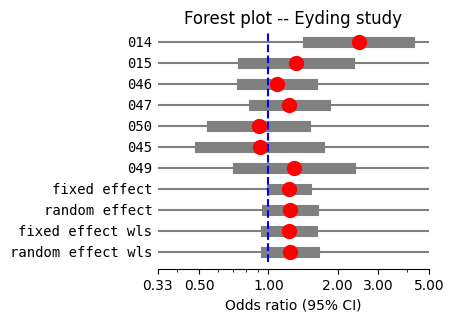

In [7]:
#| label: fig-forest
#| fig-cap: "Forest plot of the reboxetine study (response rate), using a log scale for the odds ratio"

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

fig = res_eyding.plot_forest(
    use_exp=True, # to show OR instead of logOR
)
fig.set_figwidth(3.5)
fig.set_figheight(3)

plt.axvline(x=1, ls='--', color='blue')
plt.xscale('log')

# By default, a logarithmic scale uses a LogFormatter
plt.gca().xaxis.set_major_formatter(ScalarFormatter())
plt.xticks([.33, .5, 1, 2, 3, 5])

plt.title('Forest plot -- Eyding study')
plt.xlabel('Odds ratio (95% CI)');

A forest plot uses horizontal lines to represent individual studies. Along each line, a square denotes the study's effect size, and a line extending from the square represents the confidence interval. The position of markers indicates effect direction and magnitude, while confidence interval width reflects estimate uncertainty, and visual inspection can reveal heterogeneity across studies. Ideally, the square's size would be proportional to the study's weight in the meta-analysis, reflecting factors like sample size or precision, where larger squares imply greater influence. Currently, statsmodels doesn't offer this feature, so in @fig-forest, a red dot of the same size is used to represent the effect size for all studies.

A vertical line, typically set at the value representing no effect (e.g., an odds ratio of 1), serves as a visual reference point. If a study's confidence interval crosses this line, it suggests that the effect observed in that study is not statistically significant. Finally, a diamond shape at the bottom of the plot represents the pooled effect estimate, with its width indicating the confidence interval for the combined result.

Looking at the individual studies, six out of the seven have 95% confidence intervals for the odds ratio that include 1.0. This means we cannot confidently conclude that the drug is more effective than the placebo in those studies. However, one study shows a 95% CI that does not include 1.0, suggesting a statistically significant benefit in that particular study.

A key strength of meta-analysis lies in its ability to provide a more precise estimate of the overall effect by synthesizing evidence from multiple studies, even when individual studies exhibit heterogeneous findings. The confidence interval of the pooled effect is paramount for interpretation. If it includes the value representing "no effect," such as 1.0 for odds ratios, we cannot confidently assert the presence of a genuine effect. Therefore, while statistical significance is important, clinical significance should also be considered, which involves evaluating the magnitude of the effect size.

### Fixed-effects (Woolf method)

When conducting a fixed-effects meta-analysis for comparing proportions, we often utilize the **inverse-variance method**, also known as the *Woolf method*. This approach widely used in meta-analyses, relies on a fundamental principle: *assigning weights to studies based on the inverse of their variance*.

#### Weights and variances

Specifically, the **weight** ($w_i$) given to each study is calculated as the reciprocal of its variance ($s^2_i$), which is the square of its standard error. This means studies with smaller standard errors, typically larger studies, receive higher weights, reflecting their greater precision. This weighting strategy minimizes the uncertainty of the pooled effect estimate. Mathematically, $w_i = \frac{1}{s^2_i}$, where $s^2_i$ represents the within-study variance for study $i$. We can easily extract those weights from the result dataframe.

In [8]:
# Fixed-effect weights (inverse variance)
fe_weights_eyding = res_eyding.weights_fe
print("\nFixed-effect weights (inverse variance):\n", fe_weights_eyding.round(3))

# Fixed-effect weights (normalized)
normalized_fe_weights_eyding = fe_weights_eyding / fe_weights_eyding.sum()
print("Normalized fixed-effect weights:\n", normalized_fe_weights_eyding.round(3))


Fixed-effect weights (inverse variance):
 [14.889 13.566 30.707 29.673 17.561 10.726 12.121]
Normalized fixed-effect weights:
 [0.115 0.105 0.238 0.23  0.136 0.083 0.094]


#### Confidence interval

The pooled effect size ($\bar E$) is then computed as a *weighted average*:

$$
\bar E = \frac{\sum_{i=1}^kw_iE_i}{\sum_{i=1}^kw_i} = \frac{\sum E_i(1/s^2_i)}{\sum 1/s^2_i}
$$

where $E_i$ is the effect size of the individual study.

This method operates under the assumption that all studies are estimating the same true underlying effect. This is the core *fixed-effect* assumption. The variance of the combined effect is $s = \frac{1}{\sum_{i=1}^kw_i}$, and the standard error of the pooled effect is $s_{\bar E} = \sqrt{s}$.

[The 95% confidence interval for the pooled effect](https://www.youtube.com/watch?v=DPo88xtPUaA) is calculated as $\bar{E} \pm z^\ast \times s_{\bar E}$, where $z^\ast$ is the critical value from the standard normal distribution. Note that in fixed effect meta analysis, the t distribution (see @sec-confidence-interval-mean) is rarely used. This interval reflects the precision of the pooled effect estimate, not the distribution of individual study effects.

In [9]:
# Calculate combined effect size (fixed-effect)
E_eyding_fe = (eff_eyding * fe_weights_eyding).sum() / fe_weights_eyding.sum()

# Note that we can extract the effect size and weights as follows:
#E_eyding_fe = res_eyding.mean_effect_fe
#eff_eyding = res_eyding.effect
#fe_weights_eyding = res_eyding.weights_fe

# Calculate variance and standard error (fixed-effect)
var_eyding_fe = 1 / np.sum(fe_weights_eyding)
SE_eyding_fe = var_eyding_fe**0.5

# Calculate confidence interval (fixed-effect)

# If t-distribution is preferred, with k the number of studies
#from scipy.stats import t as t_dist
#t_crit_eyding = t_dist(df=res_eyding.df).ppf((1+.95)/2)
ci_lo_E_eyding_fe = E_eyding_fe - z_crit * SE_eyding_fe
ci_up_E_eyding_fe = E_eyding_fe + z_crit * SE_eyding_fe

print(f"Combined effect size (FE) = {E_eyding_fe:.3f}")
print(f"  with SE = {SE_eyding_fe:.4f}")
print(f"  and the 95% CI ranging from {ci_lo_E_eyding_fe:.4f} \
to {ci_up_E_eyding_fe:.4f}")
print(f"The 95% CI of the total OR (FE) of {np.exp(E_eyding_fe):.2f} \
extends from {np.exp(ci_lo_E_eyding_fe):.2f} to {np.exp(ci_up_E_eyding_fe):.2f}")

Combined effect size (FE) = 0.205
  with SE = 0.0880
  and the 95% CI ranging from 0.0328 to 0.3776
The 95% CI of the total OR (FE) of 1.23 extends from 1.03 to 1.46


### Mantel-Hanszel odds-ratio

Having thoroughly examined the inverse-variance weighted fixed-effects model, we now turn to another fixed-effects approach: the **Mantel-Haenszel odds-ratio** method, abbreviated **MH**. This technique, while still operating under the assumption of a common true effect across studies, utilizes **contingency tables**, discussed in @sec-comparing-proportions, to calculate a *pooled odds ratio*, particularly useful when dealing with binary outcomes.

In contrast to the inverse-variance method, which relies on continuous effect sizes and their variances, Mantel-Haenszel directly uses the counts within each study's contingency table. While not typically a direct feature of standard meta-analysis functions within statsmodels, we can compute the Mantel-Haenszel odds-ratio using tools designed for stratified analysis, as demonstrated in [another statsmodels tutorial](https://www.statsmodels.org/dev/examples/notebooks/generated/metaanalysis1.html#Mantel-Hanszel-odds-ratio-using-contingency-tables). This necessitates transforming our data into a 2 x 2 x k table, specifically containing *event and non-event counts*, not event counts and total observations.

In [10]:
# Extract data into NumPy arrays
t = data_eyding['count_t'].values  # treatment
nt = data_eyding['nobs_t'].values  # total treatment
c = data_eyding['count_c'].values  # control
nc = data_eyding['nobs_c'].values  # total control

# Construct the 2 x 2 x k contingency table, containing
# event and non-event counts, in treatment and control
counts = np.column_stack([t, nt - t, c, nc - c])
ctables = counts.T.reshape(2, 2, -1)

# Print the first study contingency table for verification
print(f"Contingency table for study {data_eyding.index[0]}:")
print(ctables[:, :, 0])

Contingency table for study 014:
[[70 56]
 [43 85]]


We can apply the Mantel-Haenszel method using the `StratifiedTable` class to calculate the pooled log odds ratio and perform relevant statistical tests. In statsmodels, the Mantel-Haenszel confidence interval is calculated using the Robins, Breslow, and Greenland variance formula, or Sato's method when necessary.

In [11]:
import statsmodels.stats.api as smstats

# Create a StratifiedTable object from the contingency table
# The contingency table is cast to float64 to ensure compatibility
st = smstats.StratifiedTable(ctables.astype(np.float64))

# Calculate and store the pooled log odds ratio
logodds_pooled = st.logodds_pooled

# Calculate and store the standard error of the pooled log odds ratio
logodds_pooled_se = st.logodds_pooled_se

# Calculate and store the confidence interval of the pooled log odds ratio
logodds_pooled_ci = st.logodds_pooled_confint()

# Print the results with formatted output
print(f"Pooled LogOR (MH) = {logodds_pooled:.4f}")
print(f"  with SE = {logodds_pooled_se:.4f}")
print(f"  and 95% CI of {np.round(logodds_pooled_ci, 4)}")

print(f"The 95% CI of the pooled OR (MH) of {np.exp(logodds_pooled):.2f} \
extends from {np.exp(logodds_pooled_ci[0]):.2f} to {np.exp(logodds_pooled_ci[1]):.2f}")

Pooled LogOR (MH) = 0.2067
  with SE = 0.0875
  and 95% CI of [0.0352 0.3782]
The 95% CI of the pooled OR (MH) of 1.23 extends from 1.04 to 1.46


While both methods, i.e., Woolf (inverse variance) and Mantel-Haenszel, estimate the pooled odds ratio under a fixed-effects assumption, their results are not entirely consistent. Among these, the Mantel-Haenszel method is generally considered the most robust, particularly in studies with small event counts [@lee_comparison_2016].

A chi-square test assesses if the pooled odds ratio differs from one.

In [12]:
# Perform a test of the null hypothesis that the pooled odds ratio is 1 (log odds = 0)
print("MH Test null OR:")
print(st.test_null_odds())

MH Test null OR:
pvalue      0.018042566133150473
statistic   5.5920114367536735


Beyond the Mantel-Haenszel method, [Peto's method](https://www.statsdirect.com/help/meta_analysis/peto.htm) can also be used for fixed-effects meta-analysis. However, Mantel-Haenszel is particularly advantageous in trials with sparse event data. The results of the Mantel-Haenszel test and calculations are summarized below.

In [13]:
print(st.summary())

                   Estimate   LCB    UCB 
-----------------------------------------
Pooled odds           1.230   1.036 1.460
Pooled log odds       0.207   0.035 0.378
Pooled risk ratio     1.112              
                                         
                 Statistic P-value 
-----------------------------------
Test of OR=1         5.592   0.018 
Test constant OR    10.448   0.107 
                       
-----------------------
Number of tables    7  
Min n             174  
Max n             499  
Avg n             303  
Total n          2122  
-----------------------


#### Heterogeneity

In the context of fixed-effect models for comparing proportions, we assess **heterogeneity**, i.e., the variability in observed effects beyond what's expected by chance, using **Cochran's** $Q$. This statistic is calculated as the weighted sum of squared differences between individual study effects and the pooled effect, using the weights from the fixed-effect pooling method:

$$
Q = \sum w_i(E_i - \bar E)^2
$$

$Q$ follows a chi-square distribution with $k - 1$ degrees of freedom, where $k$ is the number of studies: $Q \sim \chi^2(k-1)$.

In [14]:
from scipy.stats import chi2

Q_eyding = np.sum(fe_weights_eyding * (eff_eyding - E_eyding_fe)**2)
df_eyding = len(eff_eyding) - 1 # Same as res_eyding.df
p_heterogeneity_eyding = 1 - chi2.cdf(x=Q_eyding, df=df_eyding)

print(f"Cochrane Q={Q_eyding:.3f}, \
with P value for heterogeneity = {p_heterogeneity_eyding:.6f}")

Cochrane Q=10.366, with P value for heterogeneity = 0.110064


If the P value exceeds 0.05, it indicates that the variation observed between studies is likely attributable to *random chance*, supporting the assumption of *homogeneity*. Conveniently, statsmodels offers an easily accessible function for this heterogeneity assessment.

In [15]:
res_eyding.test_homogeneity()

<class 'statsmodels.stats.base.HolderTuple'>
statistic = 10.36591423715851
pvalue = 0.11006446031462974
df = 6
distr = 'chi2'
tuple = (10.36591423715851, 0.11006446031462974)

However, $Q$ has limitations as it may have low power to detect heterogeneity with few studies and excessive power with many studies. The $I^2$ statistic quantifies the percentage of variation across studies attributable to heterogeneity rather than chance, with $I^2 = 100\% \frac{Q - \mathrm{DF}}{Q}$. It provides an intuitive measure of inconsistency and is less dependent on the number of studies than $Q$.

In [16]:
print(f"I² = {(Q_eyding - df_eyding) / Q_eyding * 100:.2f}%")
print(f"I² (internal attribute) = {res_eyding.i2 * 100:.2f}%")

I² = 42.12%
I² (internal attribute) = 42.12%


The I² value of 42.12% signifies moderate heterogeneity, meaning roughly 42% of the observed variation across studies reflects genuine differences, not just random error. Potential sources include variations in study populations, interventions, outcome measures, or designs. Although moderate heterogeneity is frequently observed, its practical impact requires contextual evaluation. Given this level of heterogeneity, a *random-effects model*, which the authors employed and will be discussed next, is more appropriate than a fixed-effect model.

### Random-effects models

When studies appear to estimate different, yet related, intervention effects, we turn to random-effects meta-analysis, such as the **chi-squared** or **DerSimonian and Laird** method. This approach allows us to address heterogeneity that isn't easily explained by other factors. Essentially, we assume that the effects observed in different studies follow a distribution, typically a normal distribution, reflecting our uncertainty about why these effects vary. The center of this distribution represents the average effect, and its width indicates the degree of heterogeneity. While the validity of any distributional assumption can be questioned, this is a common critique of random-effects models.

To account for this variability, we adjust the standard errors of the study-specific estimates ($s_i$) using tau-squared ($\tau^2$), a measure of *between-study variation*. This adjustment is estimated from the study effects and their standard errors. Notably, in heterogeneous studies, random-effects models assign relatively more weight to smaller studies than fixed-effect models, as these smaller studies provide valuable insights into the distribution of effects.

When I² is low, suggesting minimal between-study variation, a fixed-effects model might be appropriate. Fixed-effects models assume studies are conducted under similar conditions, with differences only in their power. Random-effects models, which allow effects to vary across studies, are often considered more realistic, especially in medical decision-making contexts. It's important to recognize that random-effects models don't simply eliminate heterogeneity; rather, they incorporate it into the analysis. Exploring the causes of heterogeneity remains essential, even if limited study numbers make a thorough investigation challenging. However, random-effects models require more data to achieve the same statistical power as fixed-effects models. Therefore, exercise caution when using them with sparse datasets, and seek expert statistical guidance when necessary.

#### Tau-squared

As we saw earlier, in a fixed-effect model, the weight assigned to each study is the inverse of its variance. For random-effects models, we adjust these weights by incorporating tau-squared ($\tau^2$), which accounts for between-study heterogeneity. To calculate $\tau^2$ using the DerSimonian-Laird method, we first compute the weighted sum of squared differences between individual study effects and the overall weighted mean, adjusted for the overall weighted mean squared ($q$), and the correction factor that accounts for the distribution of weights ($c$):

$$
q = \sum w_iE_i^2 - \frac{(\sum w_iE_i)^2}{\sum w_i}
\qquad
c = \frac{\sum w_i - \sum w_i^2}{\sum w_i}
$$

Then, $\tau^2$ is calculated as:

$$
\tau^2 = \frac{q - \mathrm{DF}}{c}
$$

Finally, the random-effects weights are obtained by:

$$
w_i = \frac{1}{s_i^2 + \tau^2}
$$

In [17]:
# Calculate tau-squared using fixed-effect weights
q_eyding = (
    np.sum(fe_weights_eyding * eff_eyding**2)
    - (np.sum(fe_weights_eyding * eff_eyding))**2
    / fe_weights_eyding.sum()
)
c_eyding = (
    np.sum(fe_weights_eyding)
    - np.sum(fe_weights_eyding**2)
    / np.sum(fe_weights_eyding)
)
tau2_eyding = (q_eyding - df_eyding) / c_eyding

# Print τ²
print("τ² (Eyding study)= ", round(tau2_eyding, 4))  # Same as res_eyding.tau2

# Calculate random-effect weights using tau-squared
re_weights_eyding = 1 / (var_eyding + tau2_eyding)
#re_weights_eyding = res_eyding.weights_re
print("Random-effect weights:\n", re_weights_eyding.round(3))

# Calculate normalized random-effect weights
normalized_re_weights_eyding = re_weights_eyding / re_weights_eyding.sum()
print("Normalized random-effect weights:\n", normalized_re_weights_eyding.round(3))

τ² (Eyding study)=  0.0406
Random-effect weights:
 [ 9.281  8.749 13.671 13.462 10.254  7.473  8.125]
Normalized random-effect weights:
 [0.131 0.123 0.193 0.19  0.144 0.105 0.114]


Note that the normalized random-effect weights we calculated match those reported by the authors.

#### Confidence intervals in random-effects

In contrast to fixed-effect meta-analysis, where the pooled effect size ($\bar E$) is calculated as a weighted average under the assumption of a single true effect, random-effects models account for variability between studies. As previously described, the weights are adjusted to incorporate tau-squared ($\tau^2$), reflecting this heterogeneity. The pooled effect size is *still a weighted average, but with these adjusted weights*. The variance and standard error of the pooled effect are then computed using these random-effects weights.

To determine the confidence interval, we use the same general formula, $\bar{E} \pm z^\ast \times s_{\bar E}$, but with the standard error calculated using the random-effects variance. While we still employ the standard normal distribution, or sometimes the t-distribution with small sample sizes, this interval now reflects the precision of the estimated average effect *across* studies, acknowledging that each study may be estimating a slightly different true effect.

In [18]:
# Calculate combined effect size (random-effect)
E_eyding_re = (eff_eyding * re_weights_eyding).sum() / re_weights_eyding.sum()
#E_eyding_re = (eff_eyding * normalized_re_weights_eyding).sum()

# Note that we can extract the effect size and weights as follows:
# E_eyding_re = res_eyding.mean_effect_re
# re_weights_eyding = res_eyding.weights_re

# Calculate variance and standard error (random-effect)
var_eyding_re = 1 / sum(re_weights_eyding)
SE_eyding_re = var_eyding_re**0.5

# Calculate confidence interval (random-effect)
ci_lo_E_eyding_re = E_eyding_re - z_crit * SE_eyding_re
ci_up_E_eyding_re = E_eyding_re + z_crit * SE_eyding_re

print(f"Combined effect size (RE) = {E_eyding_re:.3f}")
print(f"  with SE = {SE_eyding_re:.4f}")
print(f"  and the 95% CI ranging from {ci_lo_E_eyding_re:.4f} \
to {ci_up_E_eyding_re:.4f}")
print(f"The 95% CI of the total OR (RE) of {np.exp(E_eyding_re):.2f} \
extends from {np.exp(ci_lo_E_eyding_re):.2f} to {np.exp(ci_up_E_eyding_re):.2f}")

Combined effect size (RE) = 0.215
  with SE = 0.1187
  and the 95% CI ranging from -0.0180 to 0.4472
The 95% CI of the total OR (RE) of 1.24 extends from 0.98 to 1.56


#### Confidence intervals using the t-distribution

Setting `use_t=True` allows us to use the t-distribution, rather than the Gaussian, to calculate confidence intervals for the pooled effect size. This uses a critical t-value, with degrees of freedom determined by the number of studies minus one.

For pooled effect size confidence intervals, setting `use_t=True` allows the use of the t-distribution, with degrees of freedom determined by the number of studies minus one. However, statsmodels currently requires a separate method, utilizing total observations, to calculate t-distribution confidence intervals for individual studies. In many cases, though, the large sample sizes of individual studies make the Gaussian distribution a sufficient approximation.

In [19]:
# Perform meta-analysis using the t-distribution
res_eyding_t = combine_effects(
    effect=eff_eyding,
    variance=var_eyding,
    method_re="chi2", 
    use_t=True,
    row_names=data_eyding.index
)

res_eyding_t.conf_int_samples(
    nobs=np.array(
        data_eyding['nobs_t'] + data_eyding['nobs_c']))

# Print formatted summary results
print("Results of the meta-analysis usig the t-distribution:")
print("\nMeta-analysis summary (log):\n", res_eyding_t.summary_frame())

Results of the meta-analysis usig the t-distribution:

Meta-analysis summary (log):
                         eff    sd_eff    ci_low    ci_upp      w_fe      w_re
014                0.904595  0.259159  0.394211  1.414978  0.115202  0.130693
015                0.277574  0.271507 -0.257514  0.812662  0.104962  0.123201
046                0.084557  0.180460 -0.269999  0.439113  0.237593  0.192509
047                0.209873  0.183578 -0.150850  0.570596  0.229590  0.189568
050               -0.097580  0.238630 -0.567275  0.372114  0.135876  0.144388
045               -0.087851  0.305341 -0.690525  0.514823  0.082989  0.105232
049                0.257545  0.287226 -0.308686  0.823776  0.093788  0.114410
fixed effect       0.205226  0.087962 -0.010010  0.420462  1.000000       NaN
random effect      0.214617  0.118666 -0.075749  0.504982       NaN  1.000000
fixed effect wls   0.205226  0.115618 -0.077681  0.488133  1.000000       NaN
random effect wls  0.214617  0.122392 -0.084867  0.514100

In [20]:
from scipy.stats import t as t_dist

t_crit_eyding = t_dist(df=res_eyding.df).ppf((1+.95)/2)

ci_t_lo_E_eyding_re = E_eyding_re - t_crit_eyding * SE_eyding_re
ci_t_up_E_eyding_re = E_eyding_re + t_crit_eyding * SE_eyding_re

print(f"Combined effect size (RE) using the t-distribution = {E_eyding_re:.3f}")
print(f"  with SE = {SE_eyding_re:.4f}")
print(f"  and the 95% CI ranging from {ci_t_lo_E_eyding_re:.4f} \
to {ci_t_up_E_eyding_re:.4f}")
print(f"The 95% CI of the total OR (RE) of {np.exp(E_eyding_re):.2f} \
extends from {np.exp(ci_t_lo_E_eyding_re):.2f} to {np.exp(ci_t_up_E_eyding_re):.2f}")


Combined effect size (RE) using the t-distribution = 0.215
  with SE = 0.1187
  and the 95% CI ranging from -0.0757 to 0.5050
The 95% CI of the total OR (RE) of 1.24 extends from 0.93 to 1.66


Using the t-distribution, the 95% confidence interval for the random-effects model's overall odds ratio of 1.24 is 0.93 to 1.66, while the Gaussian distribution produces an interval of 0.98 to 1.56. With only seven studies, the t-distribution is generally considered more reliable, and both intervals include 1.0, thereby confirming the result's statistical insignificance.

### Advanced random-effects models

As we've explored, random-effects models are essential in meta-analysis for addressing between-study heterogeneity, particularly in medical studies. Traditionally, the normal distribution has been the standard assumption due to its computational ease and conceptual simplicity. However, it's crucial to recognize that the shape of the random-effects distribution directly reflects how treatment effect parameters (e.g., mean difference, log relative risk) are distributed across the population of studies, and thus, it's intricately linked to the underlying heterogeneity.

If the normal distribution assumption significantly deviates from the true heterogeneous structure, our meta-analytic results can be misleading. For instance, if the true distribution is skewed or has heavier tails than a normal distribution, using a normal distribution might lead to inaccurate estimates of the pooled effect and its uncertainty.

To address these limitations, recent advancements propose the use of flexible random-effects distribution models [@noma_meta-analysis_2022]. These models can accommodate skewness, kurtosis (peakedness), and varying tail weights, providing a more accurate representation of the heterogeneity. These flexible distributions include:

- *Skew normal distribution*: accounts for asymmetry in the distribution.
- *Skew t-distribution*: handles both skewness and heavier tails, which are common in real-world data.
- *Asymmetric subbotin distribution*: offers flexibility in modeling both skewness and kurtosis.
- *Jones-Faddy distribution*: provides a versatile framework for modeling a wide range of distribution shapes.
- *sinh-arcsinh distribution*: can capture complex distributional shapes, including skewness and heavy tails.

By employing these flexible models, we can potentially achieve more robust and reliable meta-analytic results. The choice of distribution should be guided by the characteristics of the data and our understanding of the underlying heterogeneity. For example, if we have prior knowledge or evidence suggesting that the treatment effects are likely skewed, a skew normal or skew t-distribution might be more appropriate.

The adoption of these advanced models is becoming increasingly important as we strive for greater accuracy and reliability in evidence synthesis. It's crucial to acknowledge that the conclusions and interpretations derived from meta-analyses can be substantially altered if the normal distribution assumption is not suitable. Therefore, we recommend exploring these flexible distribution models, particularly when there are reasons to believe that the normal distribution may not adequately represent the data's heterogeneity. We will not explore these methods in depth here, as they are advanced methods, but we wanted to make you aware of their existance.

## Meta-analysis of continuous data

### Overall effect size

Having explored meta-analysis techniques for counted data, including the Mantel-Haenszel method and various fixed and random-effects models, we now transition to the meta-analysis of continuous data. In this section, we will focus on estimating the **overall effect size** from continuous data, specifically the mean value of the measured variable.

In the context of meta-analysis, the primary difference between counted data and continuous data lies in the nature of the outcome measures and the effect sizes used. Counted data, often binary, involves events or proportions, such as the number of patients responding to a treatment or the occurrence of adverse events. Consequently, effect sizes like odds ratios, risk ratios, and risk differences are used to quantify the treatment effect.

Continuous data, on the other hand, involves measurements on a *continuous scale*, such as blood pressure, weight, or test scores. Here, we aim to estimate the overall mean value of the measured variable across studies. This approach is suitable when the studies are measuring the same quantity using the same scale, allowing for direct comparison of means.

As we are working with data measured on a consistent scale, we *directly combine the means and variances* to estimate the overall effect size. This approach allows us to determine the pooled mean value of the continuous variable, providing a direct and interpretable measure of the overall effect across studies.

#### Continuous data

To demonstrate the meta-analysis of continuous data, we will utilize a dataset published by Karcher [@kacker_combining_2004] that combines information from interlaboratory evaluations. The data specifically concerns the intralaboratory means and standard deviations of the amount of lead (Pb) in natural water, with measurements in nmol/kg, as derived from Table A1 in the original article [@kacker_combining_2004].

In [21]:
# Define the row names (lab identifiers)
rownames_karcher= np.array(
    ['PTB', 'NMi', 'NIMC', 'KRISS', 'LGC', 'NRC', 'IRMM', 'NIST', 'LNE'])
# Define the array of mean values for each laboratory
mean_karcher = np.array(
    [61.00, 61.40, 62.21, 62.30, 62.34, 62.60, 62.70, 62.84, 65.90])
# Define the array of standard deviation values
std_karcher = np.array(
    [0.45, 1.10 , 0.30, 0.45 , 0.62, 0.75, 0.26, 0.15, 1.35])

#### Computing overall effect size using the normal distribution

We'll leverage the statsmodels `meta_analysis` module in Python, which, as we've seen, provides a robust suite of tools for meta-analysis. Building upon our previous understanding of effect size calculations, we can directly use `combine_effects` with the mean effects and variances to perform the meta-analysis. However, it's important to note that only the normal distribution can be used if *observation counts are not provided*. This is because while the **pooled effect size** and its variance can be calculated without individual study counts, the t-distribution requires degrees of freedom to accurately estimate *individual study/lab confidence intervals*. Without the sample sizes (counts), `combine_effects` cannot calculate these degrees of freedom, and therefore must default to the normal distribution for those individual confidence intervals.

Using this approach, we can reuse our knowledge of fixed and random-effects models to estimate the overall mean or effect. We can estimate the random-effects variance, tau-squared, using the one-step chi-squared (chi2) / DerSimonian-Laird (DL) method. Note that we need the variance values for proceeding, so we need to transform the standard deviation values provided in the original article.

In [22]:
res_karcher = combine_effects(
    effect=mean_karcher,
    variance=std_karcher**2,  # variance
    method_re="dl",  # Same as 'chi2'
    use_t=False,
    row_names=rownames_karcher)

# Print key information
print("Random effects (RE) method:", res_karcher.method_re)

# Print formatted summary results
print("\nMeta-analysis summary:\n", res_karcher.summary_frame().round(4))

# Print summary statistics only
print("\nCombined effects:\n", res_karcher.summary_frame().iloc[-4:-2])

Random effects (RE) method: dl

Meta-analysis summary:
                        eff  sd_eff   ci_low   ci_upp    w_fe    w_re
PTB                61.0000  0.4500  60.1180  61.8820  0.0574  0.1231
NMi                61.4000  1.1000  59.2440  63.5560  0.0096  0.0403
NIMC               62.2100  0.3000  61.6220  62.7980  0.1292  0.1597
KRISS              62.3000  0.4500  61.4180  63.1820  0.0574  0.1231
LGC                62.3400  0.6200  61.1248  63.5552  0.0303  0.0898
NRC                62.6000  0.7500  61.1300  64.0700  0.0207  0.0710
IRMM               62.7000  0.2600  62.1904  63.2096  0.1721  0.1698
NIST               62.8400  0.1500  62.5460  63.1340  0.5169  0.1945
LNE                65.9000  1.3500  63.2540  68.5460  0.0064  0.0286
fixed effect       62.5834  0.1078  62.3720  62.7948  1.0000     NaN
random effect      62.3901  0.2457  61.9085  62.8718     NaN  1.0000
fixed effect wls   62.5834  0.1899  62.2112  62.9556  1.0000     NaN
random effect wls  62.3901  0.2948  61.8124  62

The meta-analysis of continuous data using yields straightforward results on a linear scale, unlike the log-transformed odds ratios encountered with proportions. In this analysis, the fixed-effect model estimates the combined mean effect as 62.58, with a narrow confidence interval (62.37, 62.79), indicating high precision. The random-effects model, accounting for potential between-study heterogeneity, estimates a slightly lower combined mean of 62.39, but with a *wider confidence interval* (61.91, 62.87), reflecting increased uncertainty.

#### Forest plot of continuous data (normal distribution)

Both models demonstrate a high degree of consistency, with the random-effects estimate falling well within the fixed-effect confidence interval. Notably, these results are directly interpretable on the original measurement scale, nmol/kg for lead, without requiring back-transformation, simplifying the interpretation compared to log odds ratios in proportion-based meta-analyses, as shown in @fig-forest-lab. Note that we don't need to draw a vertical line because we are not testing a specific null value.

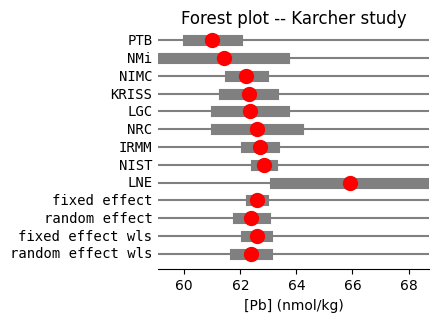

In [23]:
#| label: fig-forest-lab
#| fig-cap: "Forest plot of Lead (Pb) concentrations from Karcher et al."

fig = res_karcher.plot_forest(
    use_exp=False,  # Linear scale is only required
)
fig.set_figwidth(3.5)
fig.set_figheight(3)

plt.title('Forest plot -- Karcher study')
plt.xlabel('[Pb] (nmol/kg)');

#### Fixed-effects overall effect size

The fixed-effects analysis follows the same methodology as applied to proportions, employing a weighted average of study effects, weighted by their *inverse variances*. We will not repeat the calculation procedure here, but the manually derived fixed-effects pooled value with its confidence interval are presented below. Note that we can directly use the initial mean and standard deviation values from `mean_karcher` and `std_karcher`.

In [24]:
# Calculate the weighted effects by multiplying each effect by its fixed-effects weight
karcher_weighted = mean_karcher * res_karcher.weights_fe
#karcher_weighted = res_karcher.effect * res_karcher.weights_fe

# Calculate the pooled fixed effect by summing the weighted effects and 
# dividing by the sum of the weights
E_karcher_fe = karcher_weighted.sum() / res_karcher.weights_fe.sum()

# Calculate inverse variances and standard error (fixed-effect)
inverse_variance_karcher = 1 / std_karcher**2
SE_karcher_fe = 1 / np.sqrt(inverse_variance_karcher.sum())

# Calculate confidence interval (fixed-effect)
# If t-distribution is preferred, with k the number of studies
#t_crit_karcher = stats.t(df=res_karcher.df).ppf((1+.95)/2)
ci_lo_E_karcher_fe = E_karcher_fe - z_crit * SE_karcher_fe
ci_up_E_karcher_fe = E_karcher_fe + z_crit * SE_karcher_fe

print(f"Combined effect size in Karcher study (FE) = {E_karcher_fe:.5f}")
print(f"  with SE = {SE_karcher_fe:.4f}")
print(f"  and the 95% CI ranging from {ci_lo_E_karcher_fe:.4f} \
to {ci_up_E_karcher_fe:.4f}")

Combined effect size in Karcher study (FE) = 62.58340
  with SE = 0.1078
  and the 95% CI ranging from 62.3720 to 62.7948


#### Heterogeneity using continuous data

In meta-analysis, we assess heterogeneity—the variability in observed effects beyond chance—using Cochran's Q statistic. This statistic, calculated as the weighted sum of squared differences between individual study effects and the pooled effect, follows a chi-square distribution. While Cochran's Q is applicable to both proportion and continuous data, it's important to note its limitations: low power with few studies and excessive power with many studies. Therefore, its interpretation should be considered in light of the number of studies included in the meta-analysis.

In [25]:
print("Cochrane heterogeneity assessment in Karcher study:")
res_karcher.test_homogeneity()

Cochrane heterogeneity assessment in Karcher study:


<class 'statsmodels.stats.base.HolderTuple'>
statistic = 24.80189774185419
pvalue = 0.001679351463714887
df = 8
distr = 'chi2'
tuple = (24.80189774185419, 0.001679351463714887)

In [26]:
print(f"I² in Karcher study = {res_karcher.i2 * 100:.2f}%")

I² in Karcher study = 67.74%


The significant heterogeneity shown by the Cochran's Q test (p=`{python} round(res_karcher.test_homogeneity().pvalue, 4)`), and the high I² of `{python} round(res_karcher.i2 * 100, 2)`%, confirm that the variability in lead (Pb) measurements across laboratories is not solely due to chance, suggesting that a random-effects model would be more suitable.

#### Random-effects overall effect size

Tau-squared and the study normalized weights for the random-effects model are shown below. These values are used for calculating the confidence interval of the pooled effect size in random-effects models.

In [27]:
# Print τ²
tau2_karcher = res_karcher.tau2
print("τ² (Karcher study) = ", round(tau2_karcher, 4))

# Calculate normalized random-effect weights
normalized_re_weights_karcher = res_karcher.weights_re / res_karcher.weights_re.sum()
print("Normalized random-effect weights:\n", normalized_re_weights_karcher.round(3))

τ² (Karcher study) =  0.288
Normalized random-effect weights:
 [0.123 0.04  0.16  0.123 0.09  0.071 0.17  0.194 0.029]


In [28]:
# Calculate combined effect size (random-effect)
E_karcher_re = (mean_karcher * normalized_re_weights_karcher).sum()

# Calculate inverse variances and standard error (random-effect)
re_weights_karcher = 1 / (std_karcher**2 + tau2_karcher)
#re_weights_karcher = res_karcher.weights_re
SE_karcher_re = 1 / np.sqrt(re_weights_karcher.sum())

# Calculate confidence interval (random-effect)
ci_lo_E_karcher_re = E_karcher_re - z_crit * SE_karcher_re
ci_up_E_karcher_re = E_karcher_re + z_crit * SE_karcher_re

print(f"Combined effect size (RE) = {E_karcher_re:.3f}")
print(f"  with SE = {SE_karcher_re:.4f}")
print(f"  and the 95% CI ranging from {ci_lo_E_karcher_re:.4f} \
to {ci_up_E_karcher_re:.4f}")

Combined effect size (RE) = 62.390
  with SE = 0.2457
  and the 95% CI ranging from 61.9085 to 62.8718


### Standardized mean difference (SMD)

Effect sizes like *mean differences* or **standardized mean differences (SMDs)** are employed to summarize the treatment impact. It is a statistical measure used to combine the results of studies that have measured the same outcome using *different scales*. It quantifies the *difference between the means of two groups* (e.g., treatment and control) divided by the standard deviation, effectively expressing the treatment effect in standard deviation units.

This allows for the comparison of studies that used different measurement tools, making it particularly useful when synthesizing continuous data where direct mean differences are not comparable. Common variations include Cohen's d and Hedges' g, which adjust for small sample bias, providing a standardized way to assess the magnitude of an effect across diverse studies.

The following example is based on the code from the [statsmodels meta-analysis tutorial](https://www.statsmodels.org/dev/examples/notebooks/generated/metaanalysis1.html), with minor cosmetic changes applied for clarity and presentation.

In [29]:
# Define the row names (study identifiers)
study_smd = np.array(['Carroll', 'Grant', 'Peck', 'Donat', 'Stewart', 'Young'])
# Define the array of mean values of the treatment group
mean_t_smd = np.array([94, 98, 98, 94, 98, 96])
# Define the array of standard deviation values of the treatment group
sd_t_smd = np.array([22, 21, 28, 19, 21, 21])
# Define the array of number of observation in the treatment group
n_t_smd = np.array([60, 65, 40, 200, 50, 85])

# Define the arrays for the control group
mean_c_smd = np.array([92, 92, 88, 82, 88, 92])
sd_c_smd = np.array([20, 22, 26, 17, 22, 22])
n_c_smd = np.array([60, 65, 40, 200, 45, 85])

To calculate standardized mean differences, we use the `effectsize_smd` function. [This function computes the effect size](https://www.statsmodels.org/dev/generated/statsmodels.stats.meta_analysis.effectsize_smd.html) as the difference between the means of two groups (mean1 - mean2) standardized by an estimate of the within-group variance.

By standardizing the mean difference, we account for variations in measurement scales across the two groups, enabling us to compare studies that use different units of measurement for the same underlying construct.

Importantly, this function also allows for **bias correction**, such as **Hedges' g**, which adjusts for small sample bias, ensuring more accurate effect size estimation, particularly when sample sizes are limited.

In [30]:
from statsmodels.stats.meta_analysis import effectsize_smd

# Computing bias corrected estimate of standardized mean difference
# and estimate of variance of smd_bc
smd_bc, var_smbd = effectsize_smd(
    mean1=mean_t_smd,
    sd1=sd_t_smd,
    nobs1=n_t_smd,
    mean2=mean_c_smd,
    sd2=sd_c_smd,
    nobs2=n_c_smd)

We then combine these standardized mean differences using meta-analysis techniques utilized throughout the chapter, to estimate the overall effect size across all studies, and generate the corresponding forest plot (@fig-forest-smd).

In [31]:
res_smb = combine_effects(
    effect=smd_bc,
    variance=var_smbd,
    method_re="dl",  # Same as 'chi2'
    use_t=False,
    row_names=study_smd)

# Print formatted summary results
print("\nMeta-analysis summary (SMD):\n", res_smb.summary_frame().round(4))


Meta-analysis summary (SMD):
                       eff  sd_eff  ci_low  ci_upp    w_fe    w_re
Carroll            0.0945  0.1827 -0.2635  0.4526  0.1239  0.1575
Grant              0.2774  0.1763 -0.0681  0.6229  0.1330  0.1628
Peck               0.3665  0.2256 -0.0756  0.8087  0.0813  0.1262
Donat              0.6644  0.1027  0.4630  0.8658  0.3916  0.2327
Stewart            0.4618  0.2083  0.0535  0.8701  0.0953  0.1379
Young              0.1852  0.1537 -0.1161  0.4865  0.1749  0.1827
fixed effect       0.4150  0.0643  0.2889  0.5410  1.0000     NaN
random effect      0.3585  0.1055  0.1518  0.5652     NaN  1.0000
fixed effect wls   0.4150  0.0992  0.2205  0.6095  1.0000     NaN
random effect wls  0.3585  0.0903  0.1814  0.5355     NaN  1.0000


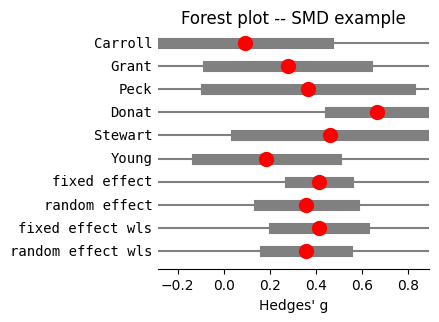

In [32]:
#| label: fig-forest-smd
#| fig-cap: "Forest plot of Hedges' g standardized mean difference from the SMD example"

fig = res_smb.plot_forest(
    use_exp=False,  # Linear scale is only required
)
fig.set_figwidth(3.5)
fig.set_figheight(3)

plt.title('Forest plot -- SMD example')
plt.xlabel("Hedges' g");

Hedges' g is a refinement of Cohen's d, we encounterd in @sec-statistical-power-and-sample-size, @sec-comparing-two-unpaired-means, @sec-comparing-paired-data, and @sec-comparing-models, specifically designed to address bias in small samples. Both measures are critical for power analysis and provide valuable information alongside t-test results. As we discussed earlier, a precise estimation of the effect size is important for the power of a study.

## Conclusion

This chapter has provided a comprehensive overview of meta-analysis, a powerful tool for synthesizing evidence across multiple studies. We began by establishing the fundamental assumptions underlying meta-analytic techniques, emphasizing the importance of study selection, data extraction, and the potential for bias.

We then delved into the meta-analysis of counted data, specifically focusing on the comparison of two independent proportions. We explored fixed-effects models, including the Mantel-Haenszel method, which assumes a common true effect across studies. These models, while straightforward, are sensitive to heterogeneity, prompting our discussion of random-effects models that account for between-study variability. Heterogeneity was examined using Cochran's Q test and the I² statistic. We highlighted the importance of these measures in determining the appropriateness of fixed versus random-effects models. We also explored how weights are assigned in both fixed and random-effects models, emphasizing how they influence the pooled effect size.

Transitioning to continuous data, we explored two distinct approaches: estimating the overall effect size and calculating the standardized mean difference (SMD). When studies measured the same outcome on a consistent scale, we demonstrated how to directly combine means and variances to estimate the overall effect size. In cases where studies employed different measurement scales, we utilized the `effectsize_smd` function to compute Hedges' g, a bias-corrected SMD, and subsequently combined these standardized effect sizes using meta-analysis techniques.

We demonstrated the application of these models using `summary_frame`, which provides tabular summaries of the pooled effects, and `plot_forest`, helping us to visualize individual study effects and their confidence intervals, facilitating a clear understanding of the overall treatment effect. We also discussed the use of the t-distribution in calculating confidence intervals, highlighting its importance when dealing with a small number of studies, as this distribution is more appropriate than the Gaussian distribution in those cases.

By covering both counted and continuous data, and exploring various effect size measures and modeling approaches, this chapter has equipped us with the foundational knowledge and practical skills necessary to conduct and interpret meta-analyses. We have emphasized the importance of understanding the assumptions, limitations, and appropriate applications of each method, enabling us to draw robust and meaningful conclusions from synthesized evidence.

## Cheat sheet

```python
from statsmodels.stats.meta_analysis import (
    effectsize_2proportions,
    effectsize_smd,
    combine_effects)
```

### Meta-analysis of counted data

```python
# Calculate effect sizes (log odds ratios) and variances
eff, var = effectsize_2proportions(
    count1=count1,  # count positive in treatment group
    nobs1=nobs1,    # number of observation in treatment group
    count2=count2,  # count positive in control group
    nobs2=nobs2,    # number of observation in control group
    statistic="odds-ratio")

# Perform fixed- and random-effects meta-analysis (chi2/DL method)
res = combine_effects(
    effect=eff,
    variance=var,
    method_re="chi2",  # One-step chi2/DL estimate for RE variance τ²
    use_t=False,
    row_names=row_names)

# Print the summary results
res.summary_frame()          # LogOR
np.exp(res.summary_frame())  # OR

# Retrieving key information
res.effect
res.mean_effect_fe
res.weights_fe
res.df  # Degrees of freedom
res.mean_effect_re
res.method_re
res_eyding.tau2
res.weights_re
```

### Mantel-Hanszel odds-raio

```python
import statsmodels.stats.api as smstats

# Construct the 2 x 2 x k contingency table, containing
# event and non-event counts, in treatment and control
counts = np.column_stack(
    [count1, nobs1 - count1, count2, nobs2 - count2])
ctables = counts.T.reshape(2, 2, -1)

# Create a StratifiedTable object from the contingency table
# The contingency table is cast to float64 to ensure compatibility
st = smstats.StratifiedTable(ctables.astype(np.float64))

st.logodds_pooled           # Pooled log odds ratio
st.logodds_pooled_se        # Standard error of the pooled logOR
st.logodds_pooled_confint() # Confidence interval of the pooled logOR

# Test of the null hypothesis that the pooled LogOR is 0 (OR=1)
st.test_null_odds()

# MH summary table
st.summary()
```

### Heterogeneity

```python
# Cochran's Q χ² test
res.test_homogeneity()

# I²
res.i2
```

### Meta-analysis using the t-distribution

```python
res = combine_effects(
    effect=eff,
    variance=var,
    method_re="chi2", 
    use_t=True,
    row_names=row_names)

res.conf_int_samples(
    nobs=np.array(data['nobs1'] + data['nobs2']))
```

### Forest plot

```python
res.plot_forest(
    use_exp=True, # to show OR instead of logOR
)
plt.axvline(x=1, ls='--', color='blue')
plt.xscale('log')
```

### Meta-analysis of continuous data

```python
# Overall effect size and variance
res = combine_effects(
    effect=mean,
    variance=std**2,  # variance
    method_re="dl",
    use_t=False,
    row_names=rownames)

# Computing bias corrected estimate of SMD and variance
smd_bc, var_smbd = effectsize_smd(
    mean1=mean1,  # mean values in group A
    sd1=sd1,      # standard deviation in group A
    nobs1=n1,     # total count in group A
    mean2=mean2,  # mean values in group B
    sd2=sd2,      # standard deviation in group B
    nobs2=n2      # total count in group A
)
```